## Training (CNN)

In [ ]:
pip install torchnet

In [ ]:
import json
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchnet.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, confusion_matrix

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/FML Project') 

## Set Device

In [ ]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


## Load Features and Labels

In [ ]:
labels = np.load(sys.path[-1]+"/Data/labels.npy")
print('Labels loaded!')

Labels loaded!


In [ ]:
image_data = np.load(sys.path[-1]+'/Data/image_data.npy')
image_data.shape
print('Image features loaded!')

Image features loaded!


In [ ]:
image_data.shape

(18543, 100, 100, 3)

In [ ]:
mu0 = np.mean(image_data[:, :, :, 0])
mu1 = np.mean(image_data[:, :, :, 1])
mu2 = np.mean(image_data[:, :, :, 2])

std0 = np.std(image_data[:, :, :, 0])
std1 = np.std(image_data[:, :, :, 1])
std2 = np.std(image_data[:, :, :, 2])

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(mu0, mu1, mu2), std=(std0, std1, std2))])

In [ ]:
image_dataset = []
for image in tqdm(image_data):
    image_dataset.append(transform(Image.fromarray((image*255).astype(np.uint8))))

100%|██████████| 18543/18543 [00:07<00:00, 2328.23it/s]


In [ ]:
image_dataset = torch.stack(image_dataset)

In [ ]:
image = image_data[0]
image.shape

(100, 100, 3)

In [ ]:
np.unique(image)

array([0.        , 0.18431373, 0.22745098, 0.23921569, 0.34509804,
       0.35294118, 0.43529412, 0.44313725, 0.45490196, 0.4627451 ,
       0.63137255, 0.63921569, 0.79215686, 0.8       , 0.83137255,
       0.84313725])

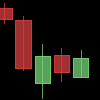

In [ ]:
image_obj = Image.fromarray((image*255).astype(np.uint8))
image_obj

In [ ]:
image = image_dataset[0]
image.unique()

tensor([-0.4190, -0.4162, -0.3770,  0.6057,  0.8357,  0.8984,  1.2278,  1.2593,
         1.6126,  1.6980,  1.7175,  1.7933,  2.6897,  2.7319,  2.9892,  3.4717,
         3.5364,  3.6814,  3.7113,  3.8465,  4.0555])

## Split Data

In [ ]:
df = pd.read_csv(sys.path[-1]+"/Data/df_final.csv")
df.head()

,stock,target_date,image_name,tweet,label
0,AAPL,2014-01-09,AAPL@2014-01-09#0.png,$ aapl i love my ipad b / c no virus and i am ...,0
1,AAPL,2014-01-10,AAPL@2014-01-10#0.png,$ aapl please help me understand the math.bill...,0
2,AAPL,2014-01-14,AAPL@2014-01-14#1.png,$ aapl what's behind the swift rise in apple s...,1
3,AAPL,2014-01-15,AAPL@2014-01-15#1.png,$ aapl what's behind the swift rise in apple s...,1
4,AAPL,2014-01-16,AAPL@2014-01-16#0.png,$ aapl expect solid results and guidance from ...,0


In [ ]:
train_ids = list(df[df['target_date'] < '2015-08-01'].index)
len(train_ids)

14040

In [ ]:
valid_ids = list(df[df['target_date'].between('2015-08-01','2015-10-01')].index)
len(valid_ids)

1910

In [ ]:
test_ids = list(df[df['target_date'] > '2015-10-01'].index)
len(test_ids)

2593

In [ ]:
dataset = TensorDataset([image_dataset.float(), torch.tensor(labels).float()])

train_set = TensorDataset([torch.utils.data.Subset(dataset, train_ids)])
valid_set = TensorDataset([torch.utils.data.Subset(dataset, valid_ids)])
test_set = TensorDataset([torch.utils.data.Subset(dataset, test_ids)])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

print('Datasets ready!')

Datasets ready!


## Evaluation Metrics

In [ ]:
def compute_accuracy(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return accuracy_score(np.array(y_true), np.array(y_pred))

def compute_f1(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return f1_score(np.array(y_true), np.array(y_pred))

def compute_MCC(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return matthews_corrcoef(np.array(y_true), np.array(y_pred))

def evaluate_metrics(preds, labels):
    labels = [int(item) for item in labels]
    preds = [0 if item < 0.5 else 1 for item in preds]
    accuracy = compute_accuracy(labels, preds)
    f1 = compute_f1(labels, preds)
    mcc = compute_MCC(labels, preds)
    cm = confusion_matrix(labels, preds)
    return accuracy, f1, mcc, cm

## Training

In [ ]:
def save_model(model, name):
    torch.save(model.state_dict(), name)

def load_model(model, name):
    weights = torch.load(name)
    model.load_state_dict(weights)
    return model

In [ ]:
def train_model(model, params, train_loader, valid_loader, test_loader, report_loss=True):

    device = params['device']
    n_epochs = params['n_epochs']
    criterion = params['criterion']
    optimizer = params['optimizer']
    scheduler = params['scheduler']

    stop = 0
    best_valid_mcc = -1

    valid_metrics = {}
    test_metrics = {}
    train_loss, valid_loss, test_loss = [], [], []
    valid_a, valid_f1, valid_mcc, valid_cm = [], [], [], []
    test_a, test_f1, test_mcc, test_cm = [], [], [], []

    f = nn.Sigmoid()

    for epoch in range(n_epochs):

        model.train()
        train_loss_i, batch, total = 0.0, 0, 0
        for data in tqdm(train_loader):
            if params['model_type'] == 'unimodal':
                x, labels = data[0][0].to(device), data[0][1].to(device)
                preds = model(x)
            elif params['model_type'] == 'bimodal':
                x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                preds = model(x_txt, x_img)
            preds = f(preds).squeeze()
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_i += loss.item()
            batch += 1
            total += labels.shape[0]
            if report_loss and batch%100==0:
                print("Batch: {}, Training Loss: {:.4f}".format(batch, train_loss_i/total))
        train_loss_i = train_loss_i / len(train_loader.dataset)

        valid_loss_i = 0.0
        valid_preds, valid_labels= [], []
        model.eval()
        with torch.no_grad():
            for data in tqdm(valid_loader):
                if params['model_type'] == 'unimodal':
                    x, labels = data[0][0].to(device), data[0][1].to(device)
                    preds = model(x)
                elif params['model_type'] == 'bimodal':
                    x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                    preds = model(x_txt, x_img)
                preds = f(preds).squeeze()
                loss = criterion(preds, labels)
                valid_loss_i += loss.item()
                valid_preds.append(preds)
                valid_labels.append(labels)
        valid_loss_i = valid_loss_i / len(valid_loader.dataset)
        valid_preds = torch.cat(valid_preds)
        valid_labels = torch.cat(valid_labels)

        valid_a_i, valid_f1_i, valid_mcc_i, valid_cm_i = evaluate_metrics(valid_preds, valid_labels)

        test_loss_i = 0.0
        test_preds, test_labels= [], []
        model.eval()
        with torch.no_grad():
            for data in tqdm(test_loader):
                if params['model_type'] == 'unimodal':
                    x, labels = data[0][0].to(device), data[0][1].to(device)
                    preds = model(x)
                elif params['model_type'] == 'bimodal':
                    x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                    preds = model(x_txt, x_img)
                preds = f(preds).squeeze()
                loss = criterion(preds, labels)
                test_loss_i += loss.item()
                test_preds.append(preds)
                test_labels.append(labels)
        test_loss_i = test_loss_i / len(test_loader.dataset)
        test_preds = torch.cat(test_preds)
        test_labels = torch.cat(test_labels)

        test_a_i, test_f1_i, test_mcc_i, test_cm_i = evaluate_metrics(test_preds, test_labels)

        scheduler.step(valid_loss_i)  # decay learning rate by validation loss

        if valid_mcc_i > best_valid_mcc:
            save_model(model, sys.path[-1]+'/Models/'+params['model_name']+'.pt')
            print("Saved model at epoch {} with validation MCC score of {:.4f}%".format(epoch+1, valid_mcc_i))
            best_valid_mcc = valid_mcc_i

        if report_loss:
            print("\n")
            print("-" * 50)
            print("Epoch ", epoch+1)
            print("Training Loss: {:.4f}, Validation Loss: {:.4f}".format(train_loss_i, valid_loss_i))
            print('Validation Results: ')
            print("Accuracy: {:.4f}".format(valid_a_i))
            print("F1 Score: {:.4f}".format(valid_f1_i))
            print("MCC Score: {:.4f}".format(valid_mcc_i))
            print('Test Results: ')
            print("Accuracy: {:.4f}".format(test_a_i))
            print("F1 Score: {:.4f}".format(test_f1_i))
            print("MCC Score: {:.4f}".format(test_mcc_i))
            print("-" * 50)
            print("\n")
        
        train_loss.append(train_loss_i)
        valid_loss.append(valid_loss_i)
        test_loss.append(test_loss_i)

        valid_a.append(valid_a_i)
        valid_f1.append(valid_f1_i)
        valid_mcc.append(valid_mcc_i)
        valid_cm.append(valid_cm_i)

        test_a.append(test_a_i)
        test_f1.append(test_f1_i)
        test_mcc.append(test_mcc_i)
        test_cm.append(test_cm_i)


        if len(valid_loss) > 0:  
            if valid_loss_i <= valid_loss[-1]:
                stop = 0
            else:
                stop += 1
                if stop >= int(params['n_stop']):   # stop training when no improvement observed in consecutive epoches
                    print("Early stopped. No improvement in validation loss for params['n_stop'] consecutive epoches.")
                    break

    valid_metrics['acc'] = valid_a
    valid_metrics['f1'] = valid_f1
    valid_metrics['mcc'] = valid_mcc
    valid_metrics['cm'] = valid_cm

    test_metrics['acc'] = test_a
    test_metrics['f1'] = test_f1
    test_metrics['mcc'] = test_mcc
    test_metrics['cm'] = test_cm

    return train_loss, valid_loss, test_loss, valid_metrics, test_metrics

## Models

In [ ]:
class Image_CNN(nn.Module):
    """
    CNN encoder for feature extraction from raw image data.
    """
    def __init__(self):
        super(Image_CNN, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3), padding=1)
        # functional layers
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.01)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2))
        # classifier
        self.classifier = nn.Linear(16*25*25, 1)

    def forward(self, x_img_raw):
        """
        Input:
            x_img_raw   | raw image data, shape = (batch_size, width, length, n_channels)
        Output:
            y           | unnormalized logits, shape = (batch_size, 1)
        """
        x = self.conv1(x_img_raw)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dropout(x)
        y = self.classifier(x)
        return y

## Unimodal

In [ ]:
# model_params = {'txt_embed_size': 768,
#                 'img_embed_size': 2048,
#                 'hidden_size': 512,
#                 'txt_H': 4,
#                 'vt_H': 4,
#                 'txt_dropout': 0.01,
#                 'img_dropout': 0.01,
#                 'vt_dropout': 0.01,
#                 'transformer_dropout': 0.01}  

best_acc, best_f1, best_mcc, best_cm = [], [], [], []

for i in range(5):

    model = Image_CNN()
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
    train_params = {'n_epochs': 30,
                    'criterion': criterion,
                    'optimizer': optimizer,
                    'scheduler': scheduler,
                    'n_stop': 8,
                    'model_name': 'Image_CNN',
                    'model_type': 'unimodal',
                    'device': device}

    train_loss, valid_loss, test_loss, valid_metrics, test_metrics = train_model(model, train_params, train_loader, valid_loader, test_loader)
        
    idx = np.argmax(test_metrics['mcc'])
    best_acc.append(test_metrics['acc'][idx])
    best_f1.append(test_metrics['f1'][idx])
    best_mcc.append(test_metrics['mcc'][idx])
    best_cm.append(test_metrics['cm'][idx])

    with open(sys.path[-1]+f"/Training Results/train_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(train_loss, f)
    with open(sys.path[-1]+f"/Training Results/valid_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(valid_loss, f)
    with open(sys.path[-1]+f"/Training Results/test_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(test_loss, f)
    with open(sys.path[-1]+f"/Training Results/valid_metrics_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(valid_metrics, f)
    with open(sys.path[-1]+f"/Training Results/test_metrics_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(test_metrics, f)

 26%|██▌       | 113/439 [00:00<00:02, 130.83it/s]

Batch: 100, Training Loss: 0.0217


 51%|█████▏    | 225/439 [00:01<00:01, 132.89it/s]

Batch: 200, Training Loss: 0.0217


 74%|███████▎  | 323/439 [00:02<00:00, 128.93it/s]

Batch: 300, Training Loss: 0.0217


 96%|█████████▌| 420/439 [00:03<00:00, 132.22it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 70.58it/s]


Saved model at epoch 1 with validation MCC score of -0.0047%


--------------------------------------------------
Epoch  1
Training Loss: 0.0217, Validation Loss: 0.0217
Validation Results: 
Accuracy: 0.5152
F1 Score: 0.3666
MCC Score: -0.0047
Test Results: 
Accuracy: 0.4917
F1 Score: 0.3436
MCC Score: 0.0096
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 131.35it/s]

Batch: 100, Training Loss: 0.0216


 51%|█████     | 223/439 [00:01<00:01, 131.04it/s]

Batch: 200, Training Loss: 0.0215


 73%|███████▎  | 321/439 [00:02<00:00, 129.53it/s]

Batch: 300, Training Loss: 0.0215


 95%|█████████▌| 419/439 [00:03<00:00, 130.98it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:00<00:00, 69.86it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0215, Validation Loss: 0.0219
Validation Results: 
Accuracy: 0.4885
F1 Score: 0.5018
MCC Score: -0.0098
Test Results: 
Accuracy: 0.4956
F1 Score: 0.5053
MCC Score: -0.0084
--------------------------------------------------




 26%|██▌       | 112/439 [00:00<00:02, 130.68it/s]

Batch: 100, Training Loss: 0.0214


 51%|█████     | 223/439 [00:01<00:01, 130.50it/s]

Batch: 200, Training Loss: 0.0214


 72%|███████▏  | 318/439 [00:02<00:00, 128.92it/s]

Batch: 300, Training Loss: 0.0214


 97%|█████████▋| 426/439 [00:03<00:00, 129.85it/s]

Batch: 400, Training Loss: 0.0214


100%|██████████| 21/21 [00:00<00:00, 70.43it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0214, Validation Loss: 0.0220
Validation Results: 
Accuracy: 0.4906
F1 Score: 0.4462
MCC Score: -0.0253
Test Results: 
Accuracy: 0.4952
F1 Score: 0.4488
MCC Score: 0.0012
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 131.18it/s]

Batch: 100, Training Loss: 0.0212


 51%|█████     | 223/439 [00:01<00:01, 132.38it/s]

Batch: 200, Training Loss: 0.0213


 73%|███████▎  | 321/439 [00:02<00:00, 132.13it/s]

Batch: 300, Training Loss: 0.0213


 95%|█████████▌| 419/439 [00:03<00:00, 131.83it/s]

Batch: 400, Training Loss: 0.0213


100%|██████████| 21/21 [00:00<00:00, 69.58it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0213, Validation Loss: 0.0221
Validation Results: 
Accuracy: 0.4864
F1 Score: 0.5156
MCC Score: -0.0078
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5420
MCC Score: -0.0063
--------------------------------------------------




 27%|██▋       | 119/439 [00:00<00:02, 123.05it/s]

Batch: 100, Training Loss: 0.0213


 51%|█████▏    | 225/439 [00:01<00:01, 129.00it/s]

Batch: 200, Training Loss: 0.0212


 73%|███████▎  | 319/439 [00:02<00:00, 130.30it/s]

Batch: 300, Training Loss: 0.0212


 95%|█████████▍| 417/439 [00:03<00:00, 130.92it/s]

Batch: 400, Training Loss: 0.0212


100%|██████████| 21/21 [00:00<00:00, 70.47it/s]


Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
Saved model at epoch 5 with validation MCC score of -0.0007%


--------------------------------------------------
Epoch  5
Training Loss: 0.0212, Validation Loss: 0.0221
Validation Results: 
Accuracy: 0.4927
F1 Score: 0.5074
MCC Score: -0.0007
Test Results: 
Accuracy: 0.4944
F1 Score: 0.5171
MCC Score: -0.0134
--------------------------------------------------




 27%|██▋       | 120/439 [00:00<00:02, 128.14it/s]

Batch: 100, Training Loss: 0.0209


 49%|████▊     | 214/439 [00:01<00:01, 129.18it/s]

Batch: 200, Training Loss: 0.0210


 72%|███████▏  | 318/439 [00:02<00:00, 127.38it/s]

Batch: 300, Training Loss: 0.0210


 97%|█████████▋| 424/439 [00:03<00:00, 129.59it/s]

Batch: 400, Training Loss: 0.0210


100%|██████████| 21/21 [00:00<00:00, 69.62it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0210, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.5103
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4956
F1 Score: 0.5278
MCC Score: -0.0133
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 129.17it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████     | 222/439 [00:01<00:01, 130.73it/s]

Batch: 200, Training Loss: 0.0210


 73%|███████▎  | 320/439 [00:02<00:00, 130.12it/s]

Batch: 300, Training Loss: 0.0210


 97%|█████████▋| 425/439 [00:03<00:00, 128.80it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.91it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0210, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4864
F1 Score: 0.5146
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4921
F1 Score: 0.5338
MCC Score: -0.0225
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.44it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████     | 223/439 [00:01<00:01, 131.10it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 321/439 [00:02<00:00, 131.17it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 418/439 [00:03<00:00, 129.86it/s]

Batch: 400, Training Loss: 0.0210


100%|██████████| 21/21 [00:00<00:00, 69.90it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0210, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.5088
MCC Score: -0.0088
Test Results: 
Accuracy: 0.4925
F1 Score: 0.5280
MCC Score: -0.0202
--------------------------------------------------




 27%|██▋       | 119/439 [00:00<00:02, 127.18it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 223/439 [00:01<00:01, 127.29it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 314/439 [00:02<00:00, 127.41it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 129.62it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.91it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  9
Training Loss: 0.0210, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4853
F1 Score: 0.4997
MCC Score: -0.0158
Test Results: 
Accuracy: 0.4913
F1 Score: 0.5191
MCC Score: -0.0207
--------------------------------------------------




 27%|██▋       | 118/439 [00:00<00:02, 128.40it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 224/439 [00:01<00:01, 128.95it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 318/439 [00:02<00:00, 129.88it/s]

Batch: 300, Training Loss: 0.0209


 94%|█████████▍| 413/439 [00:03<00:00, 129.78it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 70.26it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4848
F1 Score: 0.4995
MCC Score: -0.0167
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5190
MCC Score: -0.0215
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 129.92it/s]

Batch: 100, Training Loss: 0.0209


 50%|█████     | 221/439 [00:01<00:01, 123.94it/s]

Batch: 200, Training Loss: 0.0209


 74%|███████▍  | 326/439 [00:02<00:00, 128.79it/s]

Batch: 300, Training Loss: 0.0209


 97%|█████████▋| 424/439 [00:03<00:00, 130.17it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.98it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4843
F1 Score: 0.4992
MCC Score: -0.0177
Test Results: 
Accuracy: 0.4902
F1 Score: 0.5186
MCC Score: -0.0231
--------------------------------------------------




 27%|██▋       | 120/439 [00:00<00:02, 126.96it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 224/439 [00:01<00:01, 123.15it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:01, 113.32it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 415/439 [00:03<00:00, 127.51it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.27it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4843
F1 Score: 0.5003
MCC Score: -0.0173
Test Results: 
Accuracy: 0.4913
F1 Score: 0.5202
MCC Score: -0.0209
--------------------------------------------------




 28%|██▊       | 123/439 [00:00<00:02, 129.56it/s]

Batch: 100, Training Loss: 0.0209


 49%|████▉     | 217/439 [00:01<00:01, 127.24it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 321/439 [00:02<00:00, 126.62it/s]

Batch: 300, Training Loss: 0.0209


 94%|█████████▍| 414/439 [00:03<00:00, 128.88it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 70.30it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  13
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4864
F1 Score: 0.5028
MCC Score: -0.0129
Test Results: 
Accuracy: 0.4913
F1 Score: 0.5205
MCC Score: -0.0210
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.55it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 223/439 [00:01<00:01, 131.06it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 321/439 [00:02<00:00, 131.72it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 419/439 [00:03<00:00, 130.45it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.28it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4859
F1 Score: 0.5020
MCC Score: -0.0140
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 129.28it/s]

Batch: 100, Training Loss: 0.0208


 50%|████▉     | 219/439 [00:01<00:01, 130.40it/s]

Batch: 200, Training Loss: 0.0208


 72%|███████▏  | 316/439 [00:02<00:00, 128.35it/s]

Batch: 300, Training Loss: 0.0208


 94%|█████████▍| 414/439 [00:03<00:00, 129.54it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 66.96it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4869
F1 Score: 0.5035
MCC Score: -0.0117
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 28%|██▊       | 123/439 [00:00<00:02, 129.59it/s]

Batch: 100, Training Loss: 0.0210


 49%|████▉     | 215/439 [00:01<00:01, 129.79it/s]

Batch: 200, Training Loss: 0.0210


 74%|███████▍  | 324/439 [00:02<00:00, 131.23it/s]

Batch: 300, Training Loss: 0.0210


 96%|█████████▌| 422/439 [00:03<00:00, 130.46it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.74it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4853
F1 Score: 0.5013
MCC Score: -0.0152
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 129.12it/s]

Batch: 100, Training Loss: 0.0210


 50%|████▉     | 218/439 [00:01<00:01, 128.35it/s]

Batch: 200, Training Loss: 0.0209


 71%|███████▏  | 313/439 [00:02<00:00, 130.88it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 422/439 [00:03<00:00, 128.00it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.41it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  17
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4859
F1 Score: 0.5020
MCC Score: -0.0140
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 27%|██▋       | 118/439 [00:00<00:02, 126.17it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 223/439 [00:01<00:01, 129.41it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 315/439 [00:02<00:00, 127.35it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 415/439 [00:03<00:00, 109.16it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 65.01it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4859
F1 Score: 0.5020
MCC Score: -0.0140
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 28%|██▊       | 122/439 [00:00<00:02, 128.92it/s]

Batch: 100, Training Loss: 0.0208


 49%|████▉     | 216/439 [00:01<00:01, 130.80it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 321/439 [00:02<00:00, 123.76it/s]

Batch: 300, Training Loss: 0.0209


 97%|█████████▋| 425/439 [00:03<00:00, 126.63it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 62.02it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4859
F1 Score: 0.5020
MCC Score: -0.0140
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 27%|██▋       | 120/439 [00:00<00:02, 129.46it/s]

Batch: 100, Training Loss: 0.0209


 49%|████▉     | 217/439 [00:01<00:01, 131.24it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 315/439 [00:02<00:00, 129.51it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 127.84it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 58.17it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4859
F1 Score: 0.5020
MCC Score: -0.0140
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 26%|██▌       | 112/439 [00:00<00:02, 130.49it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 223/439 [00:01<00:01, 130.40it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 319/439 [00:02<00:00, 126.80it/s]

Batch: 300, Training Loss: 0.0209


 97%|█████████▋| 426/439 [00:03<00:00, 126.82it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 70.36it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4859
F1 Score: 0.5020
MCC Score: -0.0140
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 129.68it/s]

Batch: 100, Training Loss: 0.0209


 49%|████▉     | 217/439 [00:01<00:01, 128.41it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 126.34it/s]

Batch: 300, Training Loss: 0.0209


 94%|█████████▍| 414/439 [00:03<00:00, 125.16it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.09it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4859
F1 Score: 0.5020
MCC Score: -0.0140
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 131.86it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 222/439 [00:01<00:01, 131.17it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 320/439 [00:02<00:00, 130.56it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 416/439 [00:03<00:00, 126.12it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 65.58it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4859
F1 Score: 0.5020
MCC Score: -0.0140
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 27%|██▋       | 119/439 [00:00<00:02, 126.09it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 224/439 [00:01<00:01, 124.52it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 320/439 [00:02<00:00, 131.00it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 418/439 [00:03<00:00, 131.38it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.16it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4859
F1 Score: 0.5020
MCC Score: -0.0140
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 27%|██▋       | 118/439 [00:00<00:02, 127.34it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 223/439 [00:01<00:01, 126.51it/s]

Batch: 200, Training Loss: 0.0209


 71%|███████▏  | 313/439 [00:02<00:01, 119.29it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 417/439 [00:03<00:00, 122.22it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.27it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4853
F1 Score: 0.5018
MCC Score: -0.0150
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 27%|██▋       | 120/439 [00:00<00:02, 123.69it/s]

Batch: 100, Training Loss: 0.0209


 49%|████▊     | 213/439 [00:01<00:01, 129.82it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 320/439 [00:02<00:00, 119.94it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 421/439 [00:03<00:00, 122.40it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.75it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4853
F1 Score: 0.5018
MCC Score: -0.0150
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 28%|██▊       | 122/439 [00:00<00:02, 128.82it/s]

Batch: 100, Training Loss: 0.0208


 49%|████▉     | 215/439 [00:01<00:01, 129.66it/s]

Batch: 200, Training Loss: 0.0208


 74%|███████▎  | 323/439 [00:02<00:00, 129.31it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 418/439 [00:03<00:00, 128.97it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 63.37it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4853
F1 Score: 0.5018
MCC Score: -0.0150
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 28%|██▊       | 122/439 [00:00<00:02, 130.23it/s]

Batch: 100, Training Loss: 0.0209


 50%|█████     | 220/439 [00:01<00:01, 129.97it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 314/439 [00:02<00:00, 129.95it/s]

Batch: 300, Training Loss: 0.0209


 97%|█████████▋| 425/439 [00:03<00:00, 130.68it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.65it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4853
F1 Score: 0.5018
MCC Score: -0.0150
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 129.88it/s]

Batch: 100, Training Loss: 0.0208


 49%|████▉     | 217/439 [00:01<00:01, 128.09it/s]

Batch: 200, Training Loss: 0.0209


 74%|███████▍  | 324/439 [00:02<00:00, 129.89it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 421/439 [00:03<00:00, 131.17it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.04it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4853
F1 Score: 0.5018
MCC Score: -0.0150
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 129.87it/s]

Batch: 100, Training Loss: 0.0209


 50%|████▉     | 218/439 [00:01<00:01, 130.31it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 316/439 [00:02<00:00, 132.14it/s]

Batch: 300, Training Loss: 0.0209


 94%|█████████▍| 414/439 [00:03<00:00, 131.37it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 70.33it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0209, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4853
F1 Score: 0.5018
MCC Score: -0.0150
Test Results: 
Accuracy: 0.4909
F1 Score: 0.5200
MCC Score: -0.0218
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 129.46it/s]

Batch: 100, Training Loss: 0.0217


 50%|█████     | 220/439 [00:01<00:01, 129.75it/s]

Batch: 200, Training Loss: 0.0217


 72%|███████▏  | 314/439 [00:02<00:00, 129.88it/s]

Batch: 300, Training Loss: 0.0217


 96%|█████████▋| 423/439 [00:03<00:00, 130.33it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:00<00:00, 68.77it/s]


Saved model at epoch 1 with validation MCC score of -0.0190%


--------------------------------------------------
Epoch  1
Training Loss: 0.0217, Validation Loss: 0.0218
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.3811
MCC Score: -0.0190
Test Results: 
Accuracy: 0.4855
F1 Score: 0.3599
MCC Score: -0.0077
--------------------------------------------------




 26%|██▌       | 112/439 [00:00<00:02, 131.32it/s]

Batch: 100, Training Loss: 0.0215


 51%|█████     | 224/439 [00:01<00:01, 131.51it/s]

Batch: 200, Training Loss: 0.0215


 73%|███████▎  | 322/439 [00:02<00:00, 130.26it/s]

Batch: 300, Training Loss: 0.0215


 96%|█████████▌| 420/439 [00:03<00:00, 129.76it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:00<00:00, 67.61it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0215, Validation Loss: 0.0220
Validation Results: 
Accuracy: 0.4723
F1 Score: 0.5455
MCC Score: -0.0191
Test Results: 
Accuracy: 0.5010
F1 Score: 0.5672
MCC Score: -0.0112
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.70it/s]

Batch: 100, Training Loss: 0.0214


 51%|█████     | 223/439 [00:01<00:01, 132.09it/s]

Batch: 200, Training Loss: 0.0214


 73%|███████▎  | 321/439 [00:02<00:00, 131.95it/s]

Batch: 300, Training Loss: 0.0214


 95%|█████████▌| 419/439 [00:03<00:00, 132.10it/s]

Batch: 400, Training Loss: 0.0214


100%|██████████| 21/21 [00:00<00:00, 70.12it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0214, Validation Loss: 0.0220
Validation Results: 
Accuracy: 0.4812
F1 Score: 0.5067
MCC Score: -0.0201
Test Results: 
Accuracy: 0.4944
F1 Score: 0.5231
MCC Score: -0.0147
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 130.37it/s]

Batch: 100, Training Loss: 0.0212


 50%|█████     | 221/439 [00:01<00:01, 130.72it/s]

Batch: 200, Training Loss: 0.0213


 73%|███████▎  | 319/439 [00:02<00:00, 130.62it/s]

Batch: 300, Training Loss: 0.0213


 95%|█████████▍| 417/439 [00:03<00:00, 130.10it/s]

Batch: 400, Training Loss: 0.0213


100%|██████████| 21/21 [00:00<00:00, 70.52it/s]


Saved model at epoch 4 with validation MCC score of 0.0101%


--------------------------------------------------
Epoch  4
Training Loss: 0.0213, Validation Loss: 0.0220
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.5107
MCC Score: 0.0101
Test Results: 
Accuracy: 0.4998
F1 Score: 0.5173
MCC Score: -0.0015
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 130.08it/s]

Batch: 100, Training Loss: 0.0211


 51%|█████     | 223/439 [00:01<00:01, 129.97it/s]

Batch: 200, Training Loss: 0.0212


 72%|███████▏  | 315/439 [00:02<00:00, 129.07it/s]

Batch: 300, Training Loss: 0.0212


 96%|█████████▋| 423/439 [00:03<00:00, 129.17it/s]

Batch: 400, Training Loss: 0.0212


100%|██████████| 21/21 [00:00<00:00, 68.71it/s]


Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  5
Training Loss: 0.0212, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4738
F1 Score: 0.5495
MCC Score: -0.0143
Test Results: 
Accuracy: 0.5010
F1 Score: 0.5868
MCC Score: -0.0175
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 127.49it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 224/439 [00:01<00:01, 129.66it/s]

Batch: 200, Training Loss: 0.0210


 73%|███████▎  | 321/439 [00:02<00:00, 130.91it/s]

Batch: 300, Training Loss: 0.0210


 95%|█████████▌| 418/439 [00:03<00:00, 129.86it/s]

Batch: 400, Training Loss: 0.0210


100%|██████████| 21/21 [00:00<00:00, 69.57it/s]


Saved model at epoch 6 with validation MCC score of 0.0264%


--------------------------------------------------
Epoch  6
Training Loss: 0.0210, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5031
F1 Score: 0.5309
MCC Score: 0.0264
Test Results: 
Accuracy: 0.4967
F1 Score: 0.5400
MCC Score: -0.0136
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 129.80it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 223/439 [00:01<00:01, 131.40it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 321/439 [00:02<00:00, 130.86it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 419/439 [00:03<00:00, 130.78it/s]

Batch: 400, Training Loss: 0.0210


100%|██████████| 21/21 [00:00<00:00, 70.28it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0210, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5026
F1 Score: 0.5259
MCC Score: 0.0233
Test Results: 
Accuracy: 0.5017
F1 Score: 0.5386
MCC Score: -0.0020
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 129.17it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████     | 222/439 [00:01<00:01, 131.59it/s]

Batch: 200, Training Loss: 0.0210


 73%|███████▎  | 320/439 [00:02<00:00, 130.12it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 416/439 [00:03<00:00, 128.33it/s]

Batch: 400, Training Loss: 0.0210


100%|██████████| 21/21 [00:00<00:00, 67.94it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0210, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5026
F1 Score: 0.5168
MCC Score: 0.0194
Test Results: 
Accuracy: 0.4990
F1 Score: 0.5292
MCC Score: -0.0058
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 127.01it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 224/439 [00:01<00:01, 129.58it/s]

Batch: 200, Training Loss: 0.0208


 72%|███████▏  | 317/439 [00:02<00:00, 129.92it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▋| 423/439 [00:03<00:00, 129.54it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.15it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  9
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5037
F1 Score: 0.5108
MCC Score: 0.0187
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5205
MCC Score: -0.0056
--------------------------------------------------




 28%|██▊       | 122/439 [00:00<00:02, 130.07it/s]

Batch: 100, Training Loss: 0.0209


 50%|█████     | 220/439 [00:01<00:01, 130.71it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 317/439 [00:02<00:00, 130.82it/s]

Batch: 300, Training Loss: 0.0209


 94%|█████████▍| 414/439 [00:03<00:00, 130.40it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.98it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5154
MCC Score: 0.0223
Test Results: 
Accuracy: 0.4994
F1 Score: 0.5245
MCC Score: -0.0039
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 132.46it/s]

Batch: 100, Training Loss: 0.0207


 51%|█████     | 224/439 [00:01<00:01, 132.47it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 132.97it/s]

Batch: 300, Training Loss: 0.0208


 96%|█████████▌| 420/439 [00:03<00:00, 131.63it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.66it/s]


Saved model at epoch 11 with validation MCC score of 0.0271%


--------------------------------------------------
Epoch  11
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5189
MCC Score: 0.0271
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5260
MCC Score: -0.0069
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.80it/s]

Batch: 100, Training Loss: 0.0209


 50%|█████     | 221/439 [00:01<00:01, 131.00it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 319/439 [00:02<00:00, 131.63it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 417/439 [00:03<00:00, 131.11it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.65it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5189
MCC Score: 0.0271
Test Results: 
Accuracy: 0.4990
F1 Score: 0.5271
MCC Score: -0.0054
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 130.78it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████     | 224/439 [00:01<00:01, 131.54it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 131.79it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 131.03it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 70.35it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  13
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5210
MCC Score: 0.0255
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5313
MCC Score: -0.0029
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 131.75it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 223/439 [00:01<00:01, 131.12it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 321/439 [00:02<00:00, 132.21it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 419/439 [00:03<00:00, 132.01it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.98it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5313
MCC Score: -0.0029
--------------------------------------------------




 27%|██▋       | 119/439 [00:00<00:02, 128.53it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████▏    | 225/439 [00:01<00:01, 129.37it/s]

Batch: 200, Training Loss: 0.0210


 72%|███████▏  | 317/439 [00:02<00:00, 129.41it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 422/439 [00:03<00:00, 128.70it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.52it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5313
MCC Score: -0.0029
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 129.70it/s]

Batch: 100, Training Loss: 0.0207


 50%|█████     | 220/439 [00:01<00:01, 130.68it/s]

Batch: 200, Training Loss: 0.0208


 72%|███████▏  | 317/439 [00:02<00:00, 130.32it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 415/439 [00:03<00:00, 131.43it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.75it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5311
MCC Score: -0.0037
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 131.71it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 224/439 [00:01<00:01, 131.15it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 131.94it/s]

Batch: 300, Training Loss: 0.0208


 96%|█████████▌| 420/439 [00:03<00:00, 131.72it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.63it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  17
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5313
MCC Score: -0.0029
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 128.63it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 223/439 [00:01<00:01, 129.36it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 317/439 [00:02<00:00, 129.44it/s]

Batch: 300, Training Loss: 0.0209


 94%|█████████▍| 414/439 [00:03<00:00, 130.63it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.75it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5311
MCC Score: -0.0037
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.11it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 222/439 [00:01<00:01, 128.82it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 319/439 [00:02<00:00, 131.03it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 417/439 [00:03<00:00, 131.41it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.67it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5311
MCC Score: -0.0037
--------------------------------------------------




 28%|██▊       | 123/439 [00:00<00:02, 128.63it/s]

Batch: 100, Training Loss: 0.0210


 50%|█████     | 220/439 [00:01<00:01, 131.72it/s]

Batch: 200, Training Loss: 0.0210


 72%|███████▏  | 318/439 [00:02<00:00, 131.87it/s]

Batch: 300, Training Loss: 0.0210


 95%|█████████▍| 416/439 [00:03<00:00, 131.92it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.96it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5311
MCC Score: -0.0037
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 130.22it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 222/439 [00:01<00:01, 131.40it/s]

Batch: 200, Training Loss: 0.0208


 73%|███████▎  | 320/439 [00:02<00:00, 132.49it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 418/439 [00:03<00:00, 131.96it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.43it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5311
MCC Score: -0.0037
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 129.79it/s]

Batch: 100, Training Loss: 0.0209


 50%|█████     | 220/439 [00:01<00:01, 130.16it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 316/439 [00:02<00:00, 130.27it/s]

Batch: 300, Training Loss: 0.0209


 97%|█████████▋| 426/439 [00:03<00:00, 130.45it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.23it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5311
MCC Score: -0.0037
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.31it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 223/439 [00:01<00:01, 130.92it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 321/439 [00:02<00:00, 130.59it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 418/439 [00:03<00:00, 129.82it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.56it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5311
MCC Score: -0.0037
--------------------------------------------------




 27%|██▋       | 119/439 [00:00<00:02, 128.82it/s]

Batch: 100, Training Loss: 0.0210


 49%|████▉     | 215/439 [00:01<00:01, 130.73it/s]

Batch: 200, Training Loss: 0.0209


 71%|███████▏  | 313/439 [00:02<00:00, 130.51it/s]

Batch: 300, Training Loss: 0.0209


 97%|█████████▋| 424/439 [00:03<00:00, 129.54it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.22it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5311
MCC Score: -0.0037
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 129.98it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████     | 224/439 [00:01<00:01, 130.94it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 130.72it/s]

Batch: 300, Training Loss: 0.0208


 96%|█████████▌| 420/439 [00:03<00:00, 130.35it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.80it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5311
MCC Score: -0.0037
--------------------------------------------------




 27%|██▋       | 120/439 [00:00<00:02, 129.43it/s]

Batch: 100, Training Loss: 0.0208


 49%|████▊     | 213/439 [00:01<00:01, 129.38it/s]

Batch: 200, Training Loss: 0.0208


 73%|███████▎  | 319/439 [00:02<00:00, 129.33it/s]

Batch: 300, Training Loss: 0.0208


 97%|█████████▋| 425/439 [00:03<00:00, 127.49it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.85it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5311
MCC Score: -0.0037
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.88it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████     | 223/439 [00:01<00:01, 132.17it/s]

Batch: 200, Training Loss: 0.0210


 73%|███████▎  | 321/439 [00:02<00:00, 131.92it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 419/439 [00:03<00:00, 132.08it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 70.20it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5311
MCC Score: -0.0037
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.48it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████     | 223/439 [00:01<00:01, 131.02it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 321/439 [00:02<00:00, 131.24it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 419/439 [00:03<00:00, 131.27it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.87it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5311
MCC Score: -0.0037
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 130.09it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 224/439 [00:01<00:01, 130.84it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 130.42it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 417/439 [00:03<00:00, 128.49it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 67.98it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5311
MCC Score: -0.0037
--------------------------------------------------




 27%|██▋       | 119/439 [00:00<00:02, 127.82it/s]

Batch: 100, Training Loss: 0.0208


 49%|████▊     | 213/439 [00:01<00:01, 129.82it/s]

Batch: 200, Training Loss: 0.0208


 74%|███████▍  | 325/439 [00:02<00:00, 131.05it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▋| 423/439 [00:03<00:00, 131.67it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.49it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.5208
MCC Score: 0.0245
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5311
MCC Score: -0.0037
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 130.98it/s]

Batch: 100, Training Loss: 0.0216


 51%|█████     | 224/439 [00:01<00:01, 131.74it/s]

Batch: 200, Training Loss: 0.0217


 73%|███████▎  | 322/439 [00:02<00:00, 131.12it/s]

Batch: 300, Training Loss: 0.0217


 95%|█████████▌| 419/439 [00:03<00:00, 130.27it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:00<00:00, 68.99it/s]


Saved model at epoch 1 with validation MCC score of -0.0031%


--------------------------------------------------
Epoch  1
Training Loss: 0.0217, Validation Loss: 0.0219
Validation Results: 
Accuracy: 0.4806
F1 Score: 0.5479
MCC Score: -0.0031
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5681
MCC Score: -0.0196
--------------------------------------------------




 28%|██▊       | 121/439 [00:00<00:02, 128.41it/s]

Batch: 100, Training Loss: 0.0215


 49%|████▉     | 215/439 [00:01<00:01, 129.80it/s]

Batch: 200, Training Loss: 0.0215


 74%|███████▍  | 325/439 [00:02<00:00, 131.04it/s]

Batch: 300, Training Loss: 0.0215


 96%|█████████▋| 423/439 [00:03<00:00, 129.83it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:00<00:00, 67.46it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0215, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.4634
F1 Score: 0.5684
MCC Score: -0.0246
Test Results: 
Accuracy: 0.5048
F1 Score: 0.6090
MCC Score: -0.0165
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.41it/s]

Batch: 100, Training Loss: 0.0213


 51%|█████     | 223/439 [00:01<00:01, 131.64it/s]

Batch: 200, Training Loss: 0.0214


 73%|███████▎  | 321/439 [00:02<00:00, 132.01it/s]

Batch: 300, Training Loss: 0.0214


 95%|█████████▌| 419/439 [00:03<00:00, 132.31it/s]

Batch: 400, Training Loss: 0.0214


100%|██████████| 21/21 [00:00<00:00, 69.24it/s]


Saved model at epoch 3 with validation MCC score of 0.0248%


--------------------------------------------------
Epoch  3
Training Loss: 0.0214, Validation Loss: 0.0221
Validation Results: 
Accuracy: 0.4916
F1 Score: 0.5640
MCC Score: 0.0248
Test Results: 
Accuracy: 0.5056
F1 Score: 0.5888
MCC Score: -0.0069
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 132.07it/s]

Batch: 100, Training Loss: 0.0212


 51%|█████     | 223/439 [00:01<00:01, 132.68it/s]

Batch: 200, Training Loss: 0.0212


 73%|███████▎  | 321/439 [00:02<00:00, 131.61it/s]

Batch: 300, Training Loss: 0.0213


 95%|█████████▌| 419/439 [00:03<00:00, 132.59it/s]

Batch: 400, Training Loss: 0.0213


100%|██████████| 21/21 [00:00<00:00, 68.94it/s]


Saved model at epoch 4 with validation MCC score of 0.0316%


--------------------------------------------------
Epoch  4
Training Loss: 0.0213, Validation Loss: 0.0221
Validation Results: 
Accuracy: 0.5010
F1 Score: 0.5486
MCC Score: 0.0316
Test Results: 
Accuracy: 0.5106
F1 Score: 0.5665
MCC Score: 0.0111
--------------------------------------------------




 28%|██▊       | 123/439 [00:00<00:02, 129.77it/s]

Batch: 100, Training Loss: 0.0211


 50%|█████     | 220/439 [00:01<00:01, 130.78it/s]

Batch: 200, Training Loss: 0.0211


 72%|███████▏  | 318/439 [00:02<00:00, 129.93it/s]

Batch: 300, Training Loss: 0.0211


 97%|█████████▋| 425/439 [00:03<00:00, 129.23it/s]

Batch: 400, Training Loss: 0.0212


100%|██████████| 21/21 [00:00<00:00, 69.05it/s]


Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  5
Training Loss: 0.0212, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4906
F1 Score: 0.5526
MCC Score: 0.0164
Test Results: 
Accuracy: 0.5183
F1 Score: 0.5930
MCC Score: 0.0220
--------------------------------------------------




 28%|██▊       | 123/439 [00:00<00:02, 130.36it/s]

Batch: 100, Training Loss: 0.0209


 50%|█████     | 221/439 [00:01<00:01, 131.48it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 319/439 [00:02<00:00, 132.18it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 417/439 [00:03<00:00, 131.61it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.78it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.4911
F1 Score: 0.5061
MCC Score: -0.0038
Test Results: 
Accuracy: 0.5064
F1 Score: 0.5325
MCC Score: 0.0097
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 130.83it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 224/439 [00:01<00:01, 131.20it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 130.84it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 130.33it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.61it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.4895
F1 Score: 0.5093
MCC Score: -0.0051
Test Results: 
Accuracy: 0.5079
F1 Score: 0.5403
MCC Score: 0.0113
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.09it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 223/439 [00:01<00:01, 131.69it/s]

Batch: 200, Training Loss: 0.0208


 73%|███████▎  | 321/439 [00:02<00:00, 130.39it/s]

Batch: 300, Training Loss: 0.0208


 95%|█████████▍| 417/439 [00:03<00:00, 128.18it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.45it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.4927
F1 Score: 0.5059
MCC Score: -0.0013
Test Results: 
Accuracy: 0.5040
F1 Score: 0.5300
MCC Score: 0.0051
--------------------------------------------------




 28%|██▊       | 122/439 [00:00<00:02, 130.16it/s]

Batch: 100, Training Loss: 0.0207


 49%|████▊     | 214/439 [00:01<00:01, 129.32it/s]

Batch: 200, Training Loss: 0.0208


 74%|███████▍  | 324/439 [00:02<00:00, 130.91it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 422/439 [00:03<00:00, 131.17it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.59it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  9
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4921
F1 Score: 0.5165
MCC Score: 0.0021
Test Results: 
Accuracy: 0.5071
F1 Score: 0.5442
MCC Score: 0.0087
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 130.79it/s]

Batch: 100, Training Loss: 0.0207


 51%|█████     | 224/439 [00:01<00:01, 132.21it/s]

Batch: 200, Training Loss: 0.0208


 73%|███████▎  | 322/439 [00:02<00:00, 132.43it/s]

Batch: 300, Training Loss: 0.0208


 96%|█████████▌| 420/439 [00:03<00:00, 132.30it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 70.52it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4948
F1 Score: 0.5143
MCC Score: 0.0056
Test Results: 
Accuracy: 0.5079
F1 Score: 0.5403
MCC Score: 0.0113
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.82it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████     | 223/439 [00:01<00:01, 130.82it/s]

Batch: 200, Training Loss: 0.0210


 72%|███████▏  | 318/439 [00:02<00:00, 130.20it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 416/439 [00:03<00:00, 130.53it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 69.03it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4916
F1 Score: 0.5084
MCC Score: -0.0020
Test Results: 
Accuracy: 0.5056
F1 Score: 0.5368
MCC Score: 0.0070
--------------------------------------------------




 27%|██▋       | 118/439 [00:00<00:02, 127.32it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 223/439 [00:01<00:01, 128.93it/s]

Batch: 200, Training Loss: 0.0208


 73%|███████▎  | 320/439 [00:02<00:00, 131.04it/s]

Batch: 300, Training Loss: 0.0208


 95%|█████████▌| 418/439 [00:03<00:00, 130.54it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 69.53it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4927
F1 Score: 0.5074
MCC Score: -0.0007
Test Results: 
Accuracy: 0.5056
F1 Score: 0.5358
MCC Score: 0.0072
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 131.98it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 224/439 [00:01<00:01, 132.47it/s]

Batch: 200, Training Loss: 0.0208


 73%|███████▎  | 322/439 [00:02<00:00, 131.85it/s]

Batch: 300, Training Loss: 0.0208


 96%|█████████▌| 420/439 [00:03<00:00, 131.53it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 70.27it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  13
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4927
F1 Score: 0.5064
MCC Score: -0.0011
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 130.77it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 224/439 [00:01<00:01, 131.51it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 321/439 [00:02<00:00, 129.24it/s]

Batch: 300, Training Loss: 0.0208


 95%|█████████▍| 417/439 [00:03<00:00, 129.40it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 67.81it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4932
F1 Score: 0.5071
MCC Score: 0.0001
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 27%|██▋       | 118/439 [00:00<00:02, 128.46it/s]

Batch: 100, Training Loss: 0.0207


 51%|█████     | 223/439 [00:01<00:01, 128.53it/s]

Batch: 200, Training Loss: 0.0208


 73%|███████▎  | 321/439 [00:02<00:00, 131.00it/s]

Batch: 300, Training Loss: 0.0208


 95%|█████████▌| 419/439 [00:03<00:00, 131.49it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 69.43it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4932
F1 Score: 0.5071
MCC Score: 0.0001
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 28%|██▊       | 123/439 [00:00<00:02, 129.18it/s]

Batch: 100, Training Loss: 0.0208


 50%|█████     | 220/439 [00:01<00:01, 129.92it/s]

Batch: 200, Training Loss: 0.0208


 72%|███████▏  | 314/439 [00:02<00:00, 129.78it/s]

Batch: 300, Training Loss: 0.0208


 96%|█████████▋| 423/439 [00:03<00:00, 129.60it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 69.83it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4932
F1 Score: 0.5071
MCC Score: 0.0001
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 132.05it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 224/439 [00:01<00:01, 131.72it/s]

Batch: 200, Training Loss: 0.0208


 73%|███████▎  | 322/439 [00:02<00:00, 132.85it/s]

Batch: 300, Training Loss: 0.0208


 96%|█████████▌| 420/439 [00:03<00:00, 131.96it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 68.17it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  17
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4932
F1 Score: 0.5071
MCC Score: 0.0001
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 129.85it/s]

Batch: 100, Training Loss: 0.0208


 49%|████▉     | 217/439 [00:01<00:01, 129.44it/s]

Batch: 200, Training Loss: 0.0208


 71%|███████▏  | 313/439 [00:02<00:00, 129.87it/s]

Batch: 300, Training Loss: 0.0208


 97%|█████████▋| 425/439 [00:03<00:00, 130.25it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 70.18it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4932
F1 Score: 0.5071
MCC Score: 0.0001
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 130.70it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 224/439 [00:01<00:01, 131.66it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 130.56it/s]

Batch: 300, Training Loss: 0.0208


 96%|█████████▌| 420/439 [00:03<00:00, 131.21it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 69.06it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5079
MCC Score: 0.0013
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 132.02it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 224/439 [00:01<00:01, 130.96it/s]

Batch: 200, Training Loss: 0.0208


 73%|███████▎  | 322/439 [00:02<00:00, 132.71it/s]

Batch: 300, Training Loss: 0.0208


 96%|█████████▌| 420/439 [00:03<00:00, 132.27it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 68.90it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5079
MCC Score: 0.0013
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 28%|██▊       | 123/439 [00:00<00:02, 129.17it/s]

Batch: 100, Training Loss: 0.0209


 49%|████▉     | 215/439 [00:01<00:01, 129.66it/s]

Batch: 200, Training Loss: 0.0209


 74%|███████▍  | 325/439 [00:02<00:00, 130.72it/s]

Batch: 300, Training Loss: 0.0208


 96%|█████████▌| 422/439 [00:03<00:00, 130.09it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 67.65it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5079
MCC Score: 0.0013
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.29it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 223/439 [00:01<00:01, 131.23it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 321/439 [00:02<00:00, 131.26it/s]

Batch: 300, Training Loss: 0.0208


 95%|█████████▌| 419/439 [00:03<00:00, 131.21it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 67.71it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5079
MCC Score: 0.0013
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.86it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 223/439 [00:01<00:01, 132.21it/s]

Batch: 200, Training Loss: 0.0208


 73%|███████▎  | 321/439 [00:02<00:00, 132.43it/s]

Batch: 300, Training Loss: 0.0208


 95%|█████████▌| 419/439 [00:03<00:00, 131.44it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 69.23it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5079
MCC Score: 0.0013
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 130.93it/s]

Batch: 100, Training Loss: 0.0207


 51%|█████     | 224/439 [00:01<00:01, 131.62it/s]

Batch: 200, Training Loss: 0.0208


 73%|███████▎  | 322/439 [00:02<00:00, 132.48it/s]

Batch: 300, Training Loss: 0.0208


 96%|█████████▌| 420/439 [00:03<00:00, 131.99it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 68.68it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5079
MCC Score: 0.0013
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 130.81it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████     | 224/439 [00:01<00:01, 132.17it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 131.75it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 131.63it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 69.69it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5079
MCC Score: 0.0013
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 132.22it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 224/439 [00:01<00:01, 132.66it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 132.44it/s]

Batch: 300, Training Loss: 0.0208


 96%|█████████▌| 420/439 [00:03<00:00, 131.93it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 68.36it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5079
MCC Score: 0.0013
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 28%|██▊       | 122/439 [00:00<00:02, 128.47it/s]

Batch: 100, Training Loss: 0.0209


 49%|████▉     | 215/439 [00:01<00:01, 130.39it/s]

Batch: 200, Training Loss: 0.0209


 71%|███████▏  | 313/439 [00:02<00:00, 131.44it/s]

Batch: 300, Training Loss: 0.0208


 97%|█████████▋| 425/439 [00:03<00:00, 132.85it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 69.26it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5079
MCC Score: 0.0013
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 131.86it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 224/439 [00:01<00:01, 132.38it/s]

Batch: 200, Training Loss: 0.0208


 73%|███████▎  | 322/439 [00:02<00:00, 132.06it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 132.77it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 69.74it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5079
MCC Score: 0.0013
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 132.87it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 224/439 [00:01<00:01, 131.45it/s]

Batch: 200, Training Loss: 0.0208


 73%|███████▎  | 322/439 [00:02<00:00, 131.63it/s]

Batch: 300, Training Loss: 0.0208


 96%|█████████▌| 420/439 [00:03<00:00, 131.42it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 69.15it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5079
MCC Score: 0.0013
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 129.73it/s]

Batch: 100, Training Loss: 0.0209


 50%|█████     | 220/439 [00:01<00:01, 129.39it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 318/439 [00:02<00:00, 132.21it/s]

Batch: 300, Training Loss: 0.0208


 95%|█████████▍| 416/439 [00:03<00:00, 132.76it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 69.39it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0208, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5079
MCC Score: 0.0013
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5332
MCC Score: 0.0052
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 131.04it/s]

Batch: 100, Training Loss: 0.0218


 51%|█████     | 224/439 [00:01<00:01, 130.88it/s]

Batch: 200, Training Loss: 0.0217


 73%|███████▎  | 322/439 [00:02<00:00, 131.54it/s]

Batch: 300, Training Loss: 0.0217


 96%|█████████▌| 420/439 [00:03<00:00, 131.32it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 68.59it/s]


Saved model at epoch 1 with validation MCC score of 0.0293%


--------------------------------------------------
Epoch  1
Training Loss: 0.0217, Validation Loss: 0.0218
Validation Results: 
Accuracy: 0.5089
F1 Score: 0.5160
MCC Score: 0.0293
Test Results: 
Accuracy: 0.4940
F1 Score: 0.5068
MCC Score: -0.0121
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 131.34it/s]

Batch: 100, Training Loss: 0.0215


 51%|█████     | 223/439 [00:01<00:01, 131.85it/s]

Batch: 200, Training Loss: 0.0215


 73%|███████▎  | 321/439 [00:02<00:00, 130.52it/s]

Batch: 300, Training Loss: 0.0216


 95%|█████████▌| 419/439 [00:03<00:00, 130.99it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:00<00:00, 67.84it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0215, Validation Loss: 0.0219
Validation Results: 
Accuracy: 0.4911
F1 Score: 0.5432
MCC Score: 0.0124
Test Results: 
Accuracy: 0.5033
F1 Score: 0.5619
MCC Score: -0.0044
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 130.44it/s]

Batch: 100, Training Loss: 0.0214


 51%|█████     | 224/439 [00:01<00:01, 130.15it/s]

Batch: 200, Training Loss: 0.0213


 73%|███████▎  | 322/439 [00:02<00:00, 132.17it/s]

Batch: 300, Training Loss: 0.0214


 96%|█████████▌| 420/439 [00:03<00:00, 132.13it/s]

Batch: 400, Training Loss: 0.0214


100%|██████████| 21/21 [00:00<00:00, 69.34it/s]


Saved model at epoch 3 with validation MCC score of 0.0354%


--------------------------------------------------
Epoch  3
Training Loss: 0.0214, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.4901
F1 Score: 0.5830
MCC Score: 0.0354
Test Results: 
Accuracy: 0.5125
F1 Score: 0.6092
MCC Score: 0.0033
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 132.50it/s]

Batch: 100, Training Loss: 0.0213


 51%|█████     | 224/439 [00:01<00:01, 131.81it/s]

Batch: 200, Training Loss: 0.0213


 73%|███████▎  | 322/439 [00:02<00:00, 132.72it/s]

Batch: 300, Training Loss: 0.0213


 96%|█████████▌| 420/439 [00:03<00:00, 132.07it/s]

Batch: 400, Training Loss: 0.0213


100%|██████████| 21/21 [00:00<00:00, 69.61it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0213, Validation Loss: 0.0219
Validation Results: 
Accuracy: 0.4916
F1 Score: 0.4210
MCC Score: -0.0312
Test Results: 
Accuracy: 0.4967
F1 Score: 0.4338
MCC Score: 0.0073
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 131.65it/s]

Batch: 100, Training Loss: 0.0212


 51%|█████     | 224/439 [00:01<00:01, 132.52it/s]

Batch: 200, Training Loss: 0.0211


 73%|███████▎  | 322/439 [00:02<00:00, 132.29it/s]

Batch: 300, Training Loss: 0.0212


 96%|█████████▌| 420/439 [00:03<00:00, 132.39it/s]

Batch: 400, Training Loss: 0.0212


100%|██████████| 21/21 [00:00<00:00, 67.60it/s]


Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  5
Training Loss: 0.0212, Validation Loss: 0.0221
Validation Results: 
Accuracy: 0.5026
F1 Score: 0.5236
MCC Score: 0.0223
Test Results: 
Accuracy: 0.5106
F1 Score: 0.5397
MCC Score: 0.0175
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 128.70it/s]

Batch: 100, Training Loss: 0.0210


 50%|████▉     | 219/439 [00:01<00:01, 129.43it/s]

Batch: 200, Training Loss: 0.0210


 72%|███████▏  | 315/439 [00:02<00:00, 131.62it/s]

Batch: 300, Training Loss: 0.0210


 97%|█████████▋| 427/439 [00:03<00:00, 132.49it/s]

Batch: 400, Training Loss: 0.0210


100%|██████████| 21/21 [00:00<00:00, 67.45it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0210, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.5329
MCC Score: 0.0145
Test Results: 
Accuracy: 0.5106
F1 Score: 0.5536
MCC Score: 0.0143
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 131.07it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████     | 224/439 [00:01<00:01, 131.89it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 132.60it/s]

Batch: 300, Training Loss: 0.0210


 96%|█████████▌| 420/439 [00:03<00:00, 130.93it/s]

Batch: 400, Training Loss: 0.0210


100%|██████████| 21/21 [00:00<00:00, 69.20it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0210, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5197
MCC Score: 0.0189
Test Results: 
Accuracy: 0.5121
F1 Score: 0.5375
MCC Score: 0.0214
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 131.61it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 224/439 [00:01<00:01, 132.25it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 131.31it/s]

Batch: 300, Training Loss: 0.0210


 96%|█████████▌| 420/439 [00:03<00:00, 132.64it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 67.58it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0210, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4969
F1 Score: 0.5245
MCC Score: 0.0133
Test Results: 
Accuracy: 0.5118
F1 Score: 0.5469
MCC Score: 0.0184
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 128.59it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 223/439 [00:01<00:01, 130.96it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 321/439 [00:02<00:00, 132.53it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 419/439 [00:03<00:00, 132.55it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.44it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  9
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5037
F1 Score: 0.4979
MCC Score: 0.0138
Test Results: 
Accuracy: 0.5087
F1 Score: 0.5081
MCC Score: 0.0200
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 132.09it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 224/439 [00:01<00:01, 132.84it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 133.31it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 132.60it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.68it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5058
F1 Score: 0.5073
MCC Score: 0.0208
Test Results: 
Accuracy: 0.5098
F1 Score: 0.5180
MCC Score: 0.0205
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 131.94it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████     | 224/439 [00:01<00:01, 132.25it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 132.25it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 132.17it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.34it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5058
F1 Score: 0.5139
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5271
MCC Score: 0.0254
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.08it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 223/439 [00:01<00:01, 131.09it/s]

Batch: 200, Training Loss: 0.0210


 73%|███████▎  | 321/439 [00:02<00:00, 131.71it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 419/439 [00:03<00:00, 132.12it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.47it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5159
MCC Score: 0.0259
Test Results: 
Accuracy: 0.5133
F1 Score: 0.5298
MCC Score: 0.0256
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 131.93it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████     | 224/439 [00:01<00:01, 131.92it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 132.63it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 132.24it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.47it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  13
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5058
F1 Score: 0.5164
MCC Score: 0.0244
Test Results: 
Accuracy: 0.5137
F1 Score: 0.5328
MCC Score: 0.0258
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 130.77it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 224/439 [00:01<00:01, 130.82it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 131.09it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 131.29it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.22it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5058
F1 Score: 0.5164
MCC Score: 0.0244
Test Results: 
Accuracy: 0.5137
F1 Score: 0.5328
MCC Score: 0.0258
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 129.17it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 222/439 [00:01<00:01, 131.28it/s]

Batch: 200, Training Loss: 0.0210


 73%|███████▎  | 320/439 [00:02<00:00, 130.96it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 418/439 [00:03<00:00, 131.91it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.65it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5058
F1 Score: 0.5164
MCC Score: 0.0244
Test Results: 
Accuracy: 0.5133
F1 Score: 0.5326
MCC Score: 0.0250
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 130.12it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 223/439 [00:01<00:01, 132.71it/s]

Batch: 200, Training Loss: 0.0210


 73%|███████▎  | 321/439 [00:02<00:00, 133.18it/s]

Batch: 300, Training Loss: 0.0210


 95%|█████████▌| 419/439 [00:03<00:00, 131.43it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.34it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5133
F1 Score: 0.5326
MCC Score: 0.0250
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 131.48it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 223/439 [00:01<00:01, 131.92it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 321/439 [00:02<00:00, 131.34it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 419/439 [00:03<00:00, 131.53it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.80it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  17
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5324
MCC Score: 0.0242
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 129.69it/s]

Batch: 100, Training Loss: 0.0210


 50%|████▉     | 219/439 [00:01<00:01, 129.60it/s]

Batch: 200, Training Loss: 0.0210


 74%|███████▍  | 325/439 [00:02<00:00, 130.58it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▋| 423/439 [00:03<00:00, 132.50it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.93it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5324
MCC Score: 0.0242
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 131.82it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████     | 224/439 [00:01<00:01, 132.97it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 132.64it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 132.88it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.41it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5324
MCC Score: 0.0242
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 131.23it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 224/439 [00:01<00:01, 132.31it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 132.35it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 131.76it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.46it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5324
MCC Score: 0.0242
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 129.01it/s]

Batch: 100, Training Loss: 0.0209


 50%|█████     | 221/439 [00:01<00:01, 130.91it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 317/439 [00:02<00:00, 129.63it/s]

Batch: 300, Training Loss: 0.0209


 94%|█████████▍| 413/439 [00:03<00:00, 130.95it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.03it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5324
MCC Score: 0.0242
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 131.80it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 224/439 [00:01<00:01, 133.14it/s]

Batch: 200, Training Loss: 0.0210


 73%|███████▎  | 322/439 [00:02<00:00, 131.86it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 131.38it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.41it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5324
MCC Score: 0.0242
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 131.36it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 223/439 [00:01<00:01, 132.42it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 319/439 [00:02<00:00, 130.72it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 417/439 [00:03<00:00, 131.91it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.68it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5324
MCC Score: 0.0242
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 128.50it/s]

Batch: 100, Training Loss: 0.0210


 50%|████▉     | 219/439 [00:01<00:01, 129.73it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 315/439 [00:02<00:00, 128.70it/s]

Batch: 300, Training Loss: 0.0209


 97%|█████████▋| 425/439 [00:03<00:00, 130.75it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.52it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5324
MCC Score: 0.0242
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 132.61it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 224/439 [00:01<00:01, 132.54it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 133.01it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 132.91it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.54it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5324
MCC Score: 0.0242
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 132.67it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 224/439 [00:01<00:01, 132.97it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 132.90it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 133.01it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.61it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5324
MCC Score: 0.0242
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 129.56it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 222/439 [00:01<00:01, 129.20it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 320/439 [00:02<00:00, 128.84it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 416/439 [00:03<00:00, 131.17it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.56it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5324
MCC Score: 0.0242
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 131.59it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 224/439 [00:01<00:01, 132.30it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 132.41it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 132.88it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.49it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5324
MCC Score: 0.0242
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 131.44it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 224/439 [00:01<00:01, 130.95it/s]

Batch: 200, Training Loss: 0.0208


 73%|███████▎  | 322/439 [00:02<00:00, 132.81it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 132.14it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.24it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5324
MCC Score: 0.0242
--------------------------------------------------




 26%|██▌       | 112/439 [00:00<00:02, 130.18it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 224/439 [00:01<00:01, 130.24it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 322/439 [00:02<00:00, 130.74it/s]

Batch: 300, Training Loss: 0.0210


 96%|█████████▌| 420/439 [00:03<00:00, 130.63it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.15it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0209, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5161
MCC Score: 0.0234
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5324
MCC Score: 0.0242
--------------------------------------------------




 28%|██▊       | 123/439 [00:00<00:02, 127.99it/s]

Batch: 100, Training Loss: 0.0217


 49%|████▉     | 217/439 [00:01<00:01, 130.12it/s]

Batch: 200, Training Loss: 0.0217


 72%|███████▏  | 314/439 [00:02<00:00, 130.14it/s]

Batch: 300, Training Loss: 0.0217


 97%|█████████▋| 426/439 [00:03<00:00, 130.64it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 69.83it/s]


Saved model at epoch 1 with validation MCC score of 0.0512%


--------------------------------------------------
Epoch  1
Training Loss: 0.0217, Validation Loss: 0.0217
Validation Results: 
Accuracy: 0.5188
F1 Score: 0.5299
MCC Score: 0.0512
Test Results: 
Accuracy: 0.4933
F1 Score: 0.5071
MCC Score: -0.0138
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 130.68it/s]

Batch: 100, Training Loss: 0.0215


 51%|█████     | 224/439 [00:01<00:01, 131.65it/s]

Batch: 200, Training Loss: 0.0215


 73%|███████▎  | 322/439 [00:02<00:00, 132.62it/s]

Batch: 300, Training Loss: 0.0215


 96%|█████████▌| 420/439 [00:03<00:00, 132.34it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:00<00:00, 69.52it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0215, Validation Loss: 0.0220
Validation Results: 
Accuracy: 0.4932
F1 Score: 0.5671
MCC Score: 0.0293
Test Results: 
Accuracy: 0.5206
F1 Score: 0.5907
MCC Score: 0.0280
--------------------------------------------------




 28%|██▊       | 125/439 [00:00<00:02, 129.03it/s]

Batch: 100, Training Loss: 0.0214


 49%|████▉     | 217/439 [00:01<00:01, 129.38it/s]

Batch: 200, Training Loss: 0.0214


 74%|███████▍  | 324/439 [00:02<00:00, 130.08it/s]

Batch: 300, Training Loss: 0.0214


 95%|█████████▌| 418/439 [00:03<00:00, 128.12it/s]

Batch: 400, Training Loss: 0.0214


100%|██████████| 21/21 [00:00<00:00, 69.05it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0214, Validation Loss: 0.0219
Validation Results: 
Accuracy: 0.5042
F1 Score: 0.4143
MCC Score: -0.0117
Test Results: 
Accuracy: 0.4794
F1 Score: 0.4089
MCC Score: -0.0282
--------------------------------------------------




 27%|██▋       | 120/439 [00:00<00:02, 128.81it/s]

Batch: 100, Training Loss: 0.0212


 51%|█████▏    | 225/439 [00:01<00:01, 129.39it/s]

Batch: 200, Training Loss: 0.0213


 72%|███████▏  | 317/439 [00:02<00:00, 128.57it/s]

Batch: 300, Training Loss: 0.0213


 96%|█████████▋| 423/439 [00:03<00:00, 130.42it/s]

Batch: 400, Training Loss: 0.0213


100%|██████████| 21/21 [00:00<00:00, 69.22it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0213, Validation Loss: 0.0219
Validation Results: 
Accuracy: 0.4969
F1 Score: 0.4652
MCC Score: -0.0087
Test Results: 
Accuracy: 0.5025
F1 Score: 0.4811
MCC Score: 0.0117
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 130.69it/s]

Batch: 100, Training Loss: 0.0212


 51%|█████     | 222/439 [00:01<00:01, 131.22it/s]

Batch: 200, Training Loss: 0.0211


 73%|███████▎  | 320/439 [00:02<00:00, 131.27it/s]

Batch: 300, Training Loss: 0.0212


 95%|█████████▍| 417/439 [00:03<00:00, 130.18it/s]

Batch: 400, Training Loss: 0.0212


100%|██████████| 21/21 [00:00<00:00, 69.09it/s]


Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  5
Training Loss: 0.0212, Validation Loss: 0.0221
Validation Results: 
Accuracy: 0.4927
F1 Score: 0.4428
MCC Score: -0.0229
Test Results: 
Accuracy: 0.4848
F1 Score: 0.4538
MCC Score: -0.0227
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 126.90it/s]

Batch: 100, Training Loss: 0.0210


 49%|████▉     | 217/439 [00:01<00:01, 129.42it/s]

Batch: 200, Training Loss: 0.0211


 74%|███████▍  | 324/439 [00:02<00:00, 130.13it/s]

Batch: 300, Training Loss: 0.0210


 95%|█████████▍| 416/439 [00:03<00:00, 127.84it/s]

Batch: 400, Training Loss: 0.0210


100%|██████████| 21/21 [00:00<00:00, 69.23it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0210, Validation Loss: 0.0222
Validation Results: 
Accuracy: 0.4916
F1 Score: 0.5103
MCC Score: -0.0012
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5315
MCC Score: -0.0038
--------------------------------------------------




 26%|██▌       | 112/439 [00:00<00:02, 130.77it/s]

Batch: 100, Training Loss: 0.0210


 50%|████▉     | 218/439 [00:01<00:01, 129.54it/s]

Batch: 200, Training Loss: 0.0210


 74%|███████▍  | 325/439 [00:02<00:00, 129.28it/s]

Batch: 300, Training Loss: 0.0210


 95%|█████████▍| 417/439 [00:03<00:00, 128.89it/s]

Batch: 400, Training Loss: 0.0210


100%|██████████| 21/21 [00:00<00:00, 69.58it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0210, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4885
F1 Score: 0.5185
MCC Score: -0.0032
Test Results: 
Accuracy: 0.5067
F1 Score: 0.5514
MCC Score: 0.0061
--------------------------------------------------




 28%|██▊       | 124/439 [00:00<00:02, 130.41it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 222/439 [00:01<00:01, 130.64it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 317/439 [00:02<00:00, 130.38it/s]

Batch: 300, Training Loss: 0.0210


 94%|█████████▍| 414/439 [00:03<00:00, 129.93it/s]

Batch: 400, Training Loss: 0.0210


100%|██████████| 21/21 [00:00<00:00, 68.27it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0210, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4874
F1 Score: 0.5093
MCC Score: -0.0086
Test Results: 
Accuracy: 0.5056
F1 Score: 0.5428
MCC Score: 0.0056
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 127.87it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 223/439 [00:01<00:01, 127.08it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 316/439 [00:02<00:00, 127.14it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 419/439 [00:03<00:00, 119.42it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.91it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  9
Training Loss: 0.0210, Validation Loss: 0.0224
Validation Results: 
Accuracy: 0.4901
F1 Score: 0.5216
MCC Score: 0.0008
Test Results: 
Accuracy: 0.5056
F1 Score: 0.5536
MCC Score: 0.0030
--------------------------------------------------




 29%|██▊       | 126/439 [00:00<00:02, 129.59it/s]

Batch: 100, Training Loss: 0.0209


 50%|█████     | 220/439 [00:01<00:01, 129.43it/s]

Batch: 200, Training Loss: 0.0209


 74%|███████▍  | 325/439 [00:02<00:00, 128.35it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 417/439 [00:03<00:00, 128.99it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 67.84it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4864
F1 Score: 0.5122
MCC Score: -0.0092
Test Results: 
Accuracy: 0.5052
F1 Score: 0.5455
MCC Score: 0.0041
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 125.81it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████▏    | 225/439 [00:01<00:01, 130.15it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 317/439 [00:02<00:00, 128.14it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 422/439 [00:03<00:00, 128.99it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.72it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4880
F1 Score: 0.5095
MCC Score: -0.0076
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5419
MCC Score: 0.0032
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 127.25it/s]

Batch: 100, Training Loss: 0.0207


 50%|█████     | 221/439 [00:01<00:01, 127.36it/s]

Batch: 200, Training Loss: 0.0209


 74%|███████▍  | 325/439 [00:02<00:00, 125.94it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 416/439 [00:03<00:00, 126.28it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.94it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4885
F1 Score: 0.5058
MCC Score: -0.0082
Test Results: 
Accuracy: 0.5021
F1 Score: 0.5351
MCC Score: -0.0003
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 128.26it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 224/439 [00:01<00:01, 129.66it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 316/439 [00:02<00:00, 129.29it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 128.38it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.23it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  13
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4987
F1 Score: 0.5286
MCC Score: -0.0066
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 126.99it/s]

Batch: 100, Training Loss: 0.0210


 50%|█████     | 221/439 [00:01<00:01, 127.69it/s]

Batch: 200, Training Loss: 0.0210


 74%|███████▍  | 325/439 [00:02<00:00, 128.47it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 416/439 [00:03<00:00, 127.88it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.49it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4987
F1 Score: 0.5286
MCC Score: -0.0066
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 126.14it/s]

Batch: 100, Training Loss: 0.0210


 50%|█████     | 221/439 [00:01<00:01, 128.34it/s]

Batch: 200, Training Loss: 0.0210


 74%|███████▍  | 325/439 [00:02<00:00, 125.93it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 417/439 [00:03<00:00, 128.80it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.99it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4987
F1 Score: 0.5286
MCC Score: -0.0066
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 128.26it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████     | 223/439 [00:01<00:01, 129.49it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 315/439 [00:02<00:00, 128.30it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 419/439 [00:03<00:00, 128.12it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.46it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4987
F1 Score: 0.5286
MCC Score: -0.0066
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 127.39it/s]

Batch: 100, Training Loss: 0.0209


 50%|█████     | 221/439 [00:01<00:01, 127.94it/s]

Batch: 200, Training Loss: 0.0210


 74%|███████▍  | 325/439 [00:02<00:00, 128.60it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 416/439 [00:03<00:00, 128.65it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.13it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  17
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4987
F1 Score: 0.5286
MCC Score: -0.0066
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 126.64it/s]

Batch: 100, Training Loss: 0.0209


 50%|█████     | 221/439 [00:01<00:01, 126.12it/s]

Batch: 200, Training Loss: 0.0209


 71%|███████▏  | 313/439 [00:02<00:00, 127.96it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 418/439 [00:03<00:00, 128.37it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.11it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4987
F1 Score: 0.5286
MCC Score: -0.0066
--------------------------------------------------




 28%|██▊       | 123/439 [00:00<00:02, 129.74it/s]

Batch: 100, Training Loss: 0.0209


 49%|████▉     | 216/439 [00:01<00:01, 129.01it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 320/439 [00:02<00:00, 128.72it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 415/439 [00:03<00:00, 128.67it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 69.01it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4987
F1 Score: 0.5286
MCC Score: -0.0066
--------------------------------------------------




 28%|██▊       | 123/439 [00:00<00:02, 128.00it/s]

Batch: 100, Training Loss: 0.0208


 49%|████▊     | 214/439 [00:01<00:01, 128.71it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 318/439 [00:02<00:00, 127.32it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 422/439 [00:03<00:00, 127.14it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.94it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5285
MCC Score: -0.0074
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 126.71it/s]

Batch: 100, Training Loss: 0.0209


 50%|█████     | 221/439 [00:01<00:01, 124.85it/s]

Batch: 200, Training Loss: 0.0210


 74%|███████▍  | 325/439 [00:02<00:00, 125.67it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 416/439 [00:03<00:00, 127.51it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.28it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5285
MCC Score: -0.0074
--------------------------------------------------




 27%|██▋       | 119/439 [00:00<00:02, 128.86it/s]

Batch: 100, Training Loss: 0.0208


 51%|█████     | 223/439 [00:01<00:01, 128.74it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 318/439 [00:02<00:00, 130.45it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 416/439 [00:03<00:00, 130.58it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.97it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5285
MCC Score: -0.0074
--------------------------------------------------




 27%|██▋       | 120/439 [00:00<00:02, 130.29it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████▏    | 225/439 [00:01<00:01, 129.21it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 316/439 [00:02<00:00, 128.49it/s]

Batch: 300, Training Loss: 0.0209


 96%|█████████▌| 420/439 [00:03<00:00, 128.55it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 67.24it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5285
MCC Score: -0.0074
--------------------------------------------------




 27%|██▋       | 119/439 [00:00<00:02, 128.83it/s]

Batch: 100, Training Loss: 0.0209


 51%|█████▏    | 225/439 [00:01<00:01, 128.61it/s]

Batch: 200, Training Loss: 0.0209


 72%|███████▏  | 317/439 [00:02<00:00, 128.03it/s]

Batch: 300, Training Loss: 0.0209


 97%|█████████▋| 425/439 [00:03<00:00, 129.84it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.43it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5285
MCC Score: -0.0074
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 127.97it/s]

Batch: 100, Training Loss: 0.0209


 50%|█████     | 221/439 [00:01<00:01, 127.81it/s]

Batch: 200, Training Loss: 0.0209


 74%|███████▍  | 325/439 [00:02<00:00, 127.64it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 416/439 [00:03<00:00, 127.89it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 67.93it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5285
MCC Score: -0.0074
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 128.86it/s]

Batch: 100, Training Loss: 0.0209


 49%|████▊     | 213/439 [00:01<00:01, 130.46it/s]

Batch: 200, Training Loss: 0.0209


 73%|███████▎  | 319/439 [00:02<00:00, 129.34it/s]

Batch: 300, Training Loss: 0.0209


 94%|█████████▍| 413/439 [00:03<00:00, 129.87it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.62it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5285
MCC Score: -0.0074
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 126.36it/s]

Batch: 100, Training Loss: 0.0210


 50%|█████     | 221/439 [00:01<00:01, 127.16it/s]

Batch: 200, Training Loss: 0.0210


 74%|███████▍  | 325/439 [00:02<00:00, 128.12it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 416/439 [00:03<00:00, 128.64it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.73it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5285
MCC Score: -0.0074
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 127.78it/s]

Batch: 100, Training Loss: 0.0210


 51%|█████     | 222/439 [00:01<00:01, 128.82it/s]

Batch: 200, Training Loss: 0.0209


 71%|███████▏  | 313/439 [00:02<00:00, 127.85it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 417/439 [00:03<00:00, 127.30it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 68.94it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5285
MCC Score: -0.0074
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 128.05it/s]

Batch: 100, Training Loss: 0.0210


 50%|█████     | 221/439 [00:01<00:01, 127.89it/s]

Batch: 200, Training Loss: 0.0209


 74%|███████▍  | 325/439 [00:02<00:00, 127.68it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▍| 416/439 [00:03<00:00, 127.57it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 66.22it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5285
MCC Score: -0.0074
--------------------------------------------------




 27%|██▋       | 117/439 [00:00<00:02, 127.54it/s]

Batch: 100, Training Loss: 0.0208


 50%|█████     | 221/439 [00:01<00:01, 126.31it/s]

Batch: 200, Training Loss: 0.0209


 74%|███████▍  | 325/439 [00:02<00:00, 128.02it/s]

Batch: 300, Training Loss: 0.0209


 95%|█████████▌| 418/439 [00:03<00:00, 128.99it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 67.99it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0209, Validation Loss: 0.0223
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5036
MCC Score: -0.0082
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5285
MCC Score: -0.0074
--------------------------------------------------




## Performance

In [ ]:
print('Image-CNN')
print(25*'-')
print("Accuracy : {:.3f} ± {:.3f}".format(np.mean(best_acc), np.std(best_acc)))
print("F1-Score : {:.3f} ± {:.3f}".format(np.mean(best_f1), np.std(best_f1)))
print("MCC Score: {:.3f} ± {:.3f}".format(np.mean(best_mcc), np.std(best_mcc)))

Image-CNN
-------------------------
Accuracy : 0.509 ± 0.011
F1-Score : 0.515 ± 0.091
MCC Score: 0.017 ± 0.011


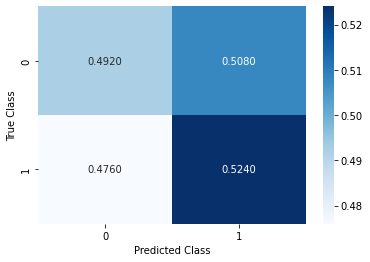

In [ ]:
import seaborn as sns

cm = np.sum(best_cm, axis=0)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt=".4f", cmap='Blues')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()